In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # put -1 to not use any

import sys
sys.path.append('/home/lumargot/hysterectomy-coach/src/py')


In [2]:
import torch
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from torchvision.ops import nms
from sklearn.metrics import classification_report, confusion_matrix

from utils import *
from visualization import *
from nets.segmentation import MaskRCNN, FasterRCNN
from loaders.hyst_dataset import HystDataModuleSeg, BBXImageTestTransform, BBXImageTrainTransform, BBXImageEvalTransform


/home/lumargot/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A new version of Albumentations is available: '2.0.7' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [3]:
laparo = [ 'Hyst_JS_1.30.23.mp4',  'Hyst_SurgU_3.21.23d_3069_3157.mp4.mp4', 'Cuff_Closure/Hyst_MedT_3.20.23r_2965_3187.mp4', 'Hyst_SurgU_3.21.23b.mp4', '!Hyst_MedT_3.21.23d_1219_1482.mp4.mp4', 'Cuff_Closure/!Hyst_MedT_3.20.23w_1604_1612.mp4' ]
robo = ['Hyst_BB_4.14.23.mp4',  'Hyst_BB_4.17.23_3630_3847.mp4.mp4', 'Cuff_Closure/Hyst_DPM_12.14.22e_3462_4190.mp4', 'Cuff_Closure/Hyst_BB_4.17.23_3936_4064.mp4', 'Hyst_BB_1.20.23b.mp4', 'Cuff_Closure/Hyst_BB_1.20.23a_3525_3753.mp4', 'Hyst_LHC_4.4.2023c.mp4' ]
concats = [ 'Bipolar', 'Vessel Sealer', 'Robot Grasper Heat', 'Laparoscopic Scissors', 'Laparoscopic Suction', 'Robot Scissors', 'monopolarhook' ]
concats = [ 'Bipolar', 'Vessel Sealer', 'Scissors', 'Suction', 'Robot Scissors', 'monopolarhook' ]

In [4]:

def construct_class_mapping(df_labels, class_column, label_column):
    df_labels = df_labels.loc[df_labels[label_column] != 'Needle']
    df_labels.loc[ df_labels[label_column].isin(concats), label_column ] = 'Others'

    unique_classes = sorted(df_labels[label_column].unique())
    class_mapping = {value: idx+1 for idx, value in enumerate(unique_classes)}
    return class_mapping

def remove_labels(df, class_mapping, class_column, label_column):

    df = df.loc[df['to_drop'] == 0]
    
    df = df.loc[df[label_column] != 'Needle']
    df.loc[ df[label_column].isin(concats), label_column ] = 'Others'

    df[class_column] = df[label_column].map(class_mapping)

    print(f"{df[[label_column, class_column]].drop_duplicates()}")
    return df.reset_index()


In [5]:
df_test = pd.read_csv('/CMF/data/lumargot/hysterectomy/mnt/surgery_tracking/csv/dataset_test.csv')
df_train = pd.read_csv('/CMF/data/lumargot/hysterectomy/mnt/surgery_tracking/csv/dataset_train_train.csv')
df_val = pd.read_csv('/CMF/data/lumargot/hysterectomy/mnt/surgery_tracking/csv/dataset_train_test.csv')

df_labels = pd.concat([df_train, df_val, df_test])

img_column = 'img_path'
seg_column = 'seg_path'
class_column = 'simplified_class'
label_column = 'simplified_label'
mount_point = '/CMF/data/lumargot/hysterectomy/mnt/surgery_tracking/'

class_mapping = construct_class_mapping(df_labels, class_column, label_column)

df_test = remove_labels(df_test, class_mapping, class_column, label_column)
df_train = remove_labels(df_train, class_mapping, class_column, label_column)
df_val = remove_labels(df_val, class_mapping, class_column, label_column)


ttdata = HystDataModuleSeg( df_test, df_test, df_test, batch_size=1, num_workers=1, 
                            img_column=img_column,seg_column=seg_column, class_column=class_column, 
                            mount_point=mount_point,train_transform=BBXImageTrainTransform(),valid_transform=BBXImageEvalTransform(), 
                            test_transform=BBXImageTestTransform())

ttdata.setup()

test_dl = ttdata.test_dataloader()
test_ds = ttdata.test_ds

     simplified_label  simplified_class
0             Grasper                 1
1       Needle Driver                 2
1117           Others                 3
   simplified_label  simplified_class
0           Grasper                 1
2     Needle Driver                 2
87           Others                 3
     simplified_label  simplified_class
0       Needle Driver                 2
1             Grasper                 1
1982           Others                 3


In [6]:
video_name = df_test['Video Name'].unique()
class_names = df_test['Instrument Name'].unique()
class_names = list(class_mapping.keys())

In [7]:
# data_dir  = '/CMF/data/lumargot/hysterectomy/mnt/surgery_tracking/output/1stage/'
# data_dir = '/CMF/data/lumargot/hysterectomy/out/new_test_nofreeze/epoch=23-val_loss=4.94'
# data_dir = '/CMF/data/lumargot/hysterectomy/out/new_test_nofreeze/v2/epoch=38-val_loss=4.61'
data_dir = '/CMF/data/lumargot/hysterectomy/out/new_test_nofreeze/epoch=20-val_loss=2.10'
# data_dir = '/CMF/data/lumargot/hysterectomy/out/new_test_nofreeze/v2/epoch=6-val_loss=2.60'
data_dir ='/CMF/data/lumargot/hysterectomy/out/custom_anchor/v2/epoch=35-val_loss=3.73'
# data_dir = '/CMF/data/lumargot/hysterectomy/out/custom_anchor/epoch=28-val_loss=14.55' #epoch=29-val_loss=6.01'
# data_dir = '/CMF/data/lumargot/hysterectomy/out/custom_anchor/epoch=32-val_loss=14.32'
# data_dir = '/CMF/data/lumargot/hysterectomy/out/new_train/epoch=122-val_loss=20.02'

# data_dir = '/CMF/data/lumargot/hysterectomy/out/last-v1'
data_dir = '/CMF/data/lumargot/hysterectomy/out/epoch=67-val_loss=1.35'

# data_dir = '/CMF/data/lumargot/hysterectomy/out/v2/last'
# data_dir = '/CMF/data/lumargot/hysterectomy/out/robot/epoch=4-val_loss=0.21'
# data_dir = '/CMF/data/lumargot/hysterectomy/out/all/epoch=5-val_loss=0.12'
# data_dir = '/CMF/data/lumargot/hysterectomy/out/all/epoch=20-val_loss=15.62'
# data_dir = '/CMF/data/lumargot/hysterectomy/out/noNeedle/last'
# data_dir = '/CMF/data/lumargot/hysterectomy/out/noNeedle/mask/last-v1'
# data_dir = '/CMF/data/lumargot/hysterectomy/out/fasterRCNN/epoch=23-val_loss=0.10'
# data_dir = '/CMF/data/lumargot/hysterectomy/out/noNeedle/mask/last-v3'

# data_dir = '/CMF/data/lumargot/hysterectomy/out/concat/v3/epoch=116-val_loss=0.09'
# data_dir = '/CMF/data/lumargot/hysterectomy/out/concat/v4/epoch=5-val_loss=0.08'
# data_dir = '/CMF/data/lumargot/hysterectomy/out/concat/balanced/epoch=10-val_loss=0.08'
data_dir = '/CMF/data/lumargot/hysterectomy/out/concat/balanced/v2/epoch=5-val_loss=0.06'
mask_dir = os.path.join(data_dir, 'masks')
pred_file = os.path.join(data_dir, 'predictions.pickle')

ckpt = data_dir + '.ckpt'
model = MaskRCNN.load_from_checkpoint(ckpt)
    
model.eval()
model.cuda()

MaskRCNN(
  (model): MaskRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): 

# Evaluation of model performance's 

In [8]:
# with open(pred_file, 'rb') as f:
#   data = pickle.load(f)

In [9]:
# # ~4min
# num_preds, num_fps, num_fns,num_low_nms = 0, 0, 0, 0
# num_small_pred, num_low_confidence, num_drop_indices = 0, 0, 0
# l_ious, l_distances = [], []
# gt, pred = [], []
# l_dice = []
# for out_img in data:
#   pred_boxes = out_img['pred_boxes']
#   pred_scores = out_img['pred_scores']
#   # pred_path = out_img['pred_mask_path']
#   pred_labels = out_img['pred_labels']

#   gt_boxes = out_img['gt_boxes']
#   gt_labels = out_img['gt_labels']
#   # gt_path= out_img['gt_mask_path']

#   pred_dic = {'boxes':pred_boxes, 'scores':pred_scores, 'labels':pred_labels}
#   gt_dic = {'boxes':gt_boxes, 'labels':gt_labels}


#   # pred_mask = np.squeeze(sitk.GetArrayFromImage(sitk.ReadImage(pred_path)).copy())
#   # gt_mask = np.squeeze(sitk.GetArrayFromImage(sitk.ReadImage(gt_path)).copy())


#   keep_indices = remove_small_predictions(pred_dic['boxes'], 30, 30)
#   num_small_pred += (pred_dic['boxes'].shape[0] - len(keep_indices))
#   pred_dic=apply_indices_selection(pred_dic, keep_indices)
  
#   SCORE_THR = 0.5
#   if (pred_dic['scores'] >= SCORE_THR).any():
#     # also do it for ground truth
#     keep = pred_dic['scores'] >= SCORE_THR
#     num_low_confidence = pred_dic['boxes'].shape[0] - len(keep)
#     pred_dic=apply_indices_selection(pred_dic, keep)

#     nms_indices = nms(torch.tensor(pred_dic['boxes']), torch.tensor(pred_dic['scores']),0.3)
#     num_low_nms += (pred_dic['boxes'].shape[0] - len(nms_indices))
#     pred_dic=apply_indices_selection(pred_dic, nms_indices)

#     if len(pred_dic['boxes'].shape) == 1: # 1 element
#       pred_dic = { k: np.expand_dims(v, axis=0) for k, v in pred_dic.items()}

#     indices_keep = select_indices_to_keep(pred_dic['labels'], pred_dic['boxes'], pred_dic['scores'])
#     num_drop_indices += (pred_dic['boxes'].shape[0] - len(indices_keep))
#     pred_dic=apply_indices_selection(pred_dic, indices_keep)

#   else:
#     num_fns += len(gt_boxes)

#   n_p, n_fp, n_fn, i, gt_ix, pred_idx = evaluate_with_fp_fn(gt_dic['boxes'], pred_dic['boxes'])

#   gt.append(torch.tensor(gt_labels[gt_ix]))
#   pred.append(torch.tensor(pred_labels[pred_idx]))

#   num_preds += n_p
#   num_fps += n_fp
#   num_fns += n_fn
#   l_ious.append(torch.tensor(i).reshape(-1))

# ious = torch.cat(l_ious, dim=0)
# pred = torch.cat(pred)
# gt = torch.cat(gt)

# total_detections = num_preds + num_fns + num_fps
# out_dict = {'Matched Prediction': num_preds,
#             'Ratio match prediction': 100*num_preds/total_detections, 
#             'False Positives':num_fps,
#             'Ratio FP': 100*num_fps/total_detections, 
#             'False Negatives':num_fns,
#             'Ration FN': 100*num_fns/total_detections, 
#             'Mean IoU': ious.mean().item(),
#             }
# print(json.dumps(out_dict, indent=2))

In [10]:
# all_gt = []
# all_pred = []

# for out_img in data:
#   pred_boxes = out_img['pred_boxes']
#   pred_scores = out_img['pred_scores']
#   pred_labels = out_img['pred_labels']
#   pred_masks =  None #out_img['pred_masks']


#   gt_boxes = out_img['gt_boxes']
#   gt_labels = out_img['gt_labels']
#   gt_masks = None #out_img['gt_masks']

#   pred_dic = {'boxes':pred_boxes, 'scores':pred_scores, 'labels':pred_labels, 'masks': pred_masks}
#   gt_dic = {'boxes':gt_boxes, 'labels':gt_labels, 'masks': gt_masks}
  
#   SCORE_THR = 0.5
#   if (pred_scores >=SCORE_THR).any():

#       keep = pred_scores >= SCORE_THR
#       pred_dic=apply_indices_selection(pred_dic, keep)

#       pred_dic = { k: torch.tensor(v) for k, v in pred_dic.items()}

#       nms_indices = nms(pred_dic['boxes'], pred_dic['scores'],0.3)
#       pred_dic=apply_indices_selection(pred_dic, nms_indices)

#       indices_keep = select_indices_to_keep(pred_dic['labels'], pred_dic['boxes'], pred_dic['scores'])
#       pred_dic=apply_indices_selection(pred_dic, indices_keep)
#   else:
#       pred_dic = {'boxes':np.array([]), 'scores':np.array([]), 'labels':np.array([])}
      
#   all_gt.append(gt_dic)
#   all_pred.append(pred_dic)

# Visualization

In [11]:
video_names = df_test['Video Name'].unique()
print(video_names)
df_vid = df_test.loc[ df_test['Video Name'] == video_names[0]] #missing big tool + needle drive

['Hyst_LHC_4.4.2023c.mp4' 'Hyst_SurgU_3.21.23b.mp4'
 '!Hyst_MedT_3.21.23d_1219_1482.mp4.mp4'
 'Cuff_Closure/Hyst_BB_1.20.23a_3525_3753.mp4'
 'Cuff_Closure/!Hyst_MedT_3.20.23w_1604_1612.mp4']


In [12]:
def compute_color_dic(class_mapping):
  names, vals = list(class_mapping.keys()), list(class_mapping.values())
  brightness = 1.0 
  hsv = [(i / len(names), 1, brightness) for i in range(len(names))]
  colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
  
  dic_color_names = {cls : col for cls,col in zip(names, colors)}
  dic_color_vals = {cls : col for cls,col in zip(vals, colors)}
  
  return dic_color_names, dic_color_vals

def convert_to_binary_mask(pred_masks):
  pred_masks[pred_masks>0.1] = 1
  if len(pred_masks.shape) >3:
      pred_masks = pred_masks.squeeze()
  if len(pred_masks.shape) == 2:
      pred_masks = pred_masks.unsqueeze(0)
  return pred_masks


In [13]:
from evaluation import *

In [14]:
y_true = []
y_pred = []
cls_names = np.insert(np.array(class_names), 0, 'Background')
color_names, color_vals = compute_color_dic(class_mapping)
display=False
stats = defaultdict(list)

with torch.no_grad():
    for idx, batch in tqdm(enumerate(test_dl), total=len(test_dl)): 
        if idx > 0:
    
            imgs = []
            img, batch = batch

            imgs.append(img)
            imgs = torch.cat(imgs)

            outputs = model.forward(imgs.cuda(), mode='test')
            img_np = 255*imgs[0].permute(1,2,0).numpy()
            
            SCORE_THR = 0.4
            pred_boxes = outputs[0]['boxes'].cpu().detach()
            pred_masks = outputs[0]['masks'].cpu().detach()

            # convert mask to binary
            pred_masks = convert_to_binary_mask(pred_masks)
            pred_labels = outputs[0]['labels'].cpu().detach()
            pred_scores = outputs[0]['scores'].cpu().detach()

            gt_masks = batch[0]['masks']
            gt_boxes = ttdata.compute_bb_mask(gt_masks, pad=0.01).numpy()
            gt_labels = batch[0]['labels'].cpu().detach().numpy()

            pred_dic = {'boxes':pred_boxes, 'scores':pred_scores, 'labels':pred_labels, 'masks': pred_masks}
            gt_dic = {'boxes':gt_boxes, 'labels':gt_labels, 'masks':gt_masks}

            if (pred_scores >=SCORE_THR).any():
                
                keep = pred_scores >= SCORE_THR
                pred_dic=apply_indices_selection(pred_dic, keep)

                nms_indices = nms(pred_dic['boxes'], pred_dic['scores'],0.3)
                pred_dic_filtered=apply_indices_selection(pred_dic, nms_indices)

                indices_keep = select_indices_to_keep(pred_dic_filtered['labels'], pred_dic_filtered['boxes'], pred_dic_filtered['scores'])
                pred_dic_filtered=apply_indices_selection(pred_dic_filtered, indices_keep)

                stats, gt_label, pred_label = get_prediction_metrics(gt_dic, pred_dic_filtered, stats, iou_threshold=0.25)
                y_true.append(torch.tensor(gt_label))
                y_pred.append(torch.tensor(pred_label))

                if display :
                    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True,  figsize=(30, 10))

                    ax1.imshow(img_np.astype(np.uint8))
                    ax1.axis('off')
                    ax1.set_title('Input Image')

                    gt_colors = [ color_vals[val] for val in gt_labels]
                    display_instances(ax=ax2, image=img_np, boxes=gt_boxes[:, [1, 0, 3, 2]], masks=gt_masks.numpy().transpose(1,2,0), 
                                    class_ids=gt_labels, class_names=cls_names, colors=gt_colors, show_mask = True, show_bbox=True,title='Ground Truth Annotations',figsize = (10,10))
                    pred_colors = [ color_vals[val] for val in pred_dic['labels'].numpy()]

                    display_instances(ax=ax3, image=img_np, boxes=pred_dic['boxes'][:, [1, 0, 3, 2]].numpy(), masks=pred_dic['masks'].numpy().transpose(1,2,0), 
                                    class_ids=pred_dic['labels'].numpy(), class_names=cls_names, colors=pred_colors, scores=pred_dic['scores'].numpy(), show_mask = True,
                                    show_bbox=True,title='Raw Output',figsize = (10,10))
                    
                    pred_colors_filtered = [ color_vals[val] for val in pred_dic_filtered['labels'].numpy()]
                    display_instances(ax=ax4, image=img_np, boxes=pred_dic_filtered['boxes'][:, [1, 0, 3, 2]].numpy(), masks=pred_dic_filtered['masks'].numpy().transpose(1,2,0), 
                                    class_ids=pred_dic_filtered['labels'].numpy(), class_names=cls_names,  colors=pred_colors, scores=pred_dic_filtered['scores'].numpy(), show_mask = True, 
                                    show_bbox=True,title='Filtered Output',figsize = (10,10),)


                    plt.show()
                    plt.close()
y_true = torch.concat(y_true)
y_pred = torch.concat(y_pred)

  0%|          | 1/15224 [00:00<32:35,  7.79it/s]To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 15224/15224 [1:09:0

In [21]:
df_pred, out_dict = compute_global_metrics(class_names, y_true, y_pred, stats, iou_threshold=0.25)

In [23]:
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
df_pred.to_csv(os.path.join(data_dir, 'prediction.csv'))
filename = os.path.join(data_dir, 'output_stats.json')
with open(filename, 'w') as file:
    json.dump(out_dict, file, indent=2)

In [24]:
out_dict

{'precision@IoU>0.25': 0.4150953224294197,
 'recall': 0.35175457956301037,
 'f1_score': 0.3808090220533773,
 'mean_box_iou': 0.27369085042924657,
 'mean_mask_iou': 0.41767327427445217,
 'mean_dice': 0.5762103073844005,
 'false_positives': 11229,
 'false_negatives': 14686,
 'true_positives': 7969,
 'average_precision_per_class': {'Grasper': 0.5957407745386798,
  'Needle Driver': 0.30186416968499397,
  'Others': 0.3872124311535137},
 'mean_average_precision': 0.4282724584590625,
 'labels': ['Grasper', 'Needle Driver', 'Others']}

In [25]:
def compute_global_metrics(classes, y_true, y_pred, stats, iou_threshold=0.5) :
    tp = sum(stats['total_tp'])
    fp = sum(stats['total_fp'])
    fn = sum(stats['total_fn'])

    mean_box_iou = np.array(stats['stats_box_iou'])
    mean_mask_iou = np.array(stats['stats_mask_iou'])
    mean_dice  = np.array(stats['stats_dice'])

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    # Compute AP per class (macro average)
    ap_per_class = {}
    for cls in classes:
        cls_id = classes.index(cls) +1
        y_true_bin = [1 if y == cls_id else 0 for y in y_true]
        y_pred_bin = [1 if y == cls_id else 0 for y in y_pred]
        if any(y_true_bin):  # Only compute AP if this class is present in GT
            ap = average_precision_score(y_true_bin, y_pred_bin)
        else:
            ap = float('nan')  # or 0.0
        ap_per_class[cls] = ap
    valid_aps = [ap for ap in ap_per_class.values() if not np.isnan(ap)]
    mean_ap = np.mean(valid_aps) if valid_aps else 0.0


    df_pred  = pd.DataFrame(data={'gt': y_true, 'pred': y_pred})
    data_stats = {f'precision@IoU>{iou_threshold}': precision,
                 'recall': recall,
                 'f1_score': f1,
                 'mean_box_iou': np.mean(mean_box_iou) ,
                 'mean_mask_iou': np.mean(mean_mask_iou) ,
                 'mean_dice': np.mean(mean_dice) ,
                 'false_positives': fp,
                 'false_negatives': fn,
                 'true_positives': tp,
                 'average_precision_per_class': ap_per_class,
                 'mean_average_precision': mean_ap,
                 'labels': classes,
                #  'pr_curve_data': {'scores': stats['scores'], 
                #                    'matches': (np.array(y_true) == np.array(y_pred)).astype(int).tolist() }
    }
    return df_pred, data_stats

In [26]:
report = classification_report(y_true, y_pred, output_dict=True)
print(report)

print(json.dumps(report, indent=2))
df_report = pd.DataFrame(report).transpose()
df_report.to_csv(os.path.join(data_dir, 'classification_report.csv'))

{'1.0': {'precision': 0.6442307692307693, 'recall': 0.6173617846750727, 'f1-score': 0.6305101535413572, 'support': 4124}, '2.0': {'precision': 0.42963885429638854, 'recall': 0.15554553651938682, 'f1-score': 0.22840119165839126, 'support': 2218}, '3.0': {'precision': 0.42314872433105166, 'recall': 0.8358942839582053, 'f1-score': 0.5618673827721545, 'support': 1627}, 'accuracy': 0.533442088091354, 'macro avg': {'precision': 0.49900611595273653, 'recall': 0.536267201717555, 'f1-score': 0.4735929093239677, 'support': 7969}, 'weighted avg': {'precision': 0.5393662499214084, 'recall': 0.533442088091354, 'f1-score': 0.5045772302764668, 'support': 7969}}
{
  "1.0": {
    "precision": 0.6442307692307693,
    "recall": 0.6173617846750727,
    "f1-score": 0.6305101535413572,
    "support": 4124
  },
  "2.0": {
    "precision": 0.42963885429638854,
    "recall": 0.15554553651938682,
    "f1-score": 0.22840119165839126,
    "support": 2218
  },
  "3.0": {
    "precision": 0.42314872433105166,
    "

Confusion matrix, without normalization
Normalized confusion matrix, avg: 0.536267201717555


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


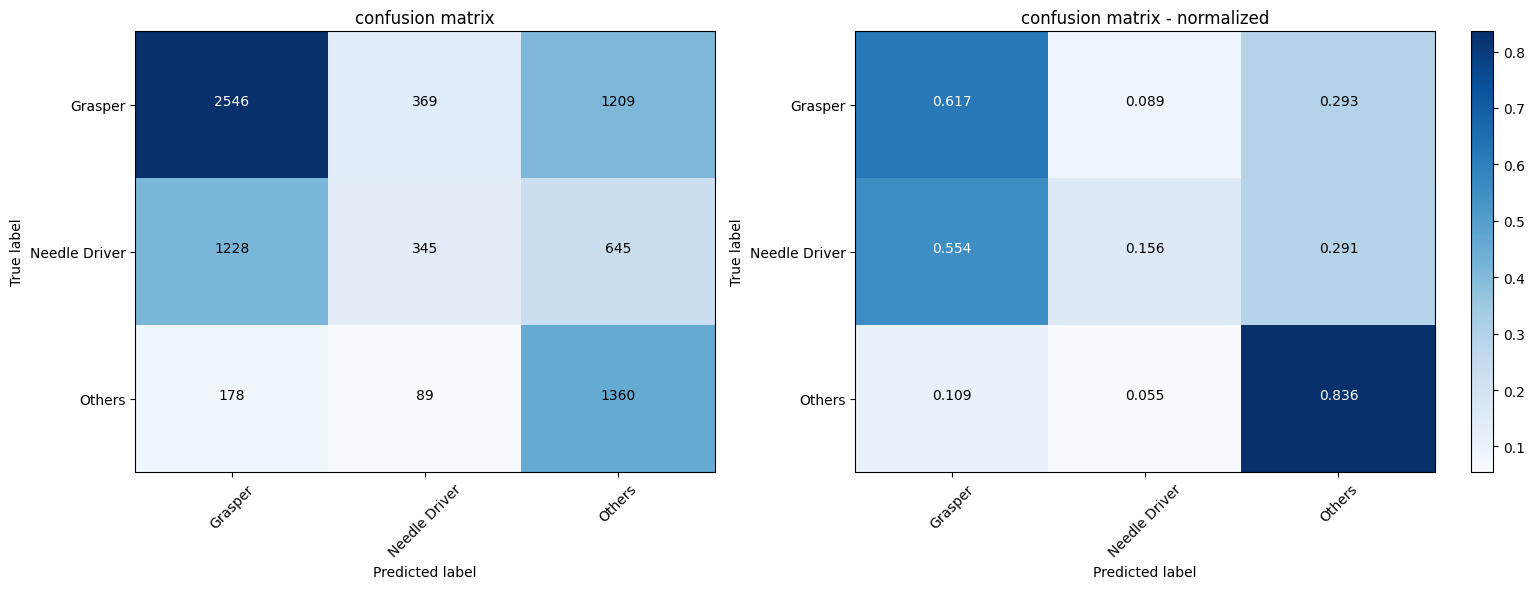

In [27]:
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=3)

# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(16,6))

plt.subplot(121)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='confusion matrix')

plt.subplot(122)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='confusion matrix - normalized')

plt.savefig(os.path.join(data_dir, 'confusion_matrix.png'))